# Analysis of adaptation time with generalized linear models
## [Yoav Ram](https://www.yoavram.com)

This notebook will demonstrate how to analyse adaptation time of a population using generalized linear models (GLM), and specificaly exponential regression. This assumes that adaptation time is a geomteric or exponential random variable since it is roughly the waiting time for an event to occur with some independent event of it occuring every generation; this neglects much of the dynamics, of course, but the idea is to get a general way to analyse adaptation time without having a clear dynamic model of the process.

#### Outline

1. The exponential distribution and how to fit data to it
1. Exponential regression, and in general, GLM
1. Simulating adaptation
1. Analysing results of simulations using exponential regression

This notebook is under the [CC-BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/) license.

The latest version of the notebook can be found on [github](https://github.com/yoavram/ipython-notebooks/blob/master/exponential%20regression%20of%20adaptation%20time.ipynb).

Thanks to [Uri Obolski](https://www.eeid.ox.ac.uk/content/dr-uri-obolski) for help with understanding GLMs.

In [142]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats, optimize
import statsmodels.api as sm
import pandas as pd
import seaborn as sns
sns.set(
    style='white',
    palette='Set1',
    context='paper',
    font_scale=1.3,
)
red, blue, green = sns.color_palette('Set1', 3)
from ipy_progressbar import ProgressBarIPyNb as ProgressBar # pip install git+https://github.com/yoavram/ipy-progressbar.git
import sys

print("Python", sys.version)
print("NumPy:", np.__version__)
print("Matplotlib:", mpl.__version__)
print("statsmodels:", sm.version.version)
print("Pandas:", pd.__version__)
print("Seaborn:", sns.__version__)

Python 3.5.2 | packaged by conda-forge | (default, Jul 26 2016, 01:37:38) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.54)]
NumPy: 1.11.2
Matplotlib: 1.5.3
statsmodels: 0.6.1
Pandas: 0.19.1
Seaborn: 0.7.1


# Exponential distribution

The pdf (probabilit density function) and cdf (cummulative distribution function) of an exponential distribution with rate λ is:
$$
f_{\lambda}(x) = \lambda e^{-\lambda x} \\
F_{\lambda}(x) = 1=e^{-\lambda x}
$$

We create two exponential random variables, with rates 1/2 and 1/4:

In [3]:
λs = np.array([1/2, 1/4])
expons = [stats.expon(scale=1/λ) for λ in λs]
[exp.mean() for exp in expons], 1/λs

([2.0, 4.0], array([ 2.,  4.]))

And we plot their pdf and cdf:

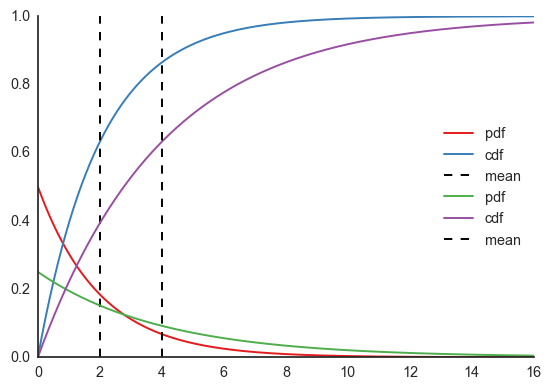

In [4]:
x = np.linspace(0, 16, 1000)
for exp in expons:
    plt.plot(x, exp.pdf(x), label='pdf')
    plt.plot(x, exp.cdf(x), label='cdf')
    plt.axvline(x=exp.mean(), color='k', ls='--', label='mean')
plt.legend(loc='center right')
sns.despine()

## Fitting an exponential distribution

Now we draw some random numbers from the same distributions:

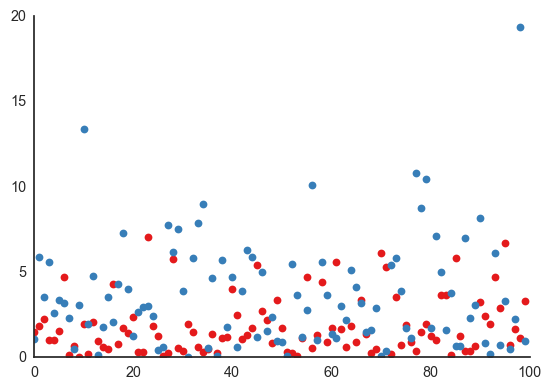

In [5]:
for exp in expons:
    y = exp.rvs(100)
    plt.plot(y, 'o')
sns.despine()

We can try to estimate the rate of the distribution from a random samples. This can done using maximum likelihood. For a given set of samples $x$, the likelihood function of λ is:
$$
L(\lambda | x) = \Pi_i{\lambda e^{-\lambda x_i}} = \lambda^n e^{-\lambda n \bar{x}}
$$
which gives $\hat{\lambda} = \frac{1}{\bar{x}}$ (although this is a biased estimator $E[\hat{\lambda}]=\frac{n}{n-1}\lambda$, see below).

In [93]:
nsamples = np.logspace(2, 5, 50, dtype=int)
estimates = [
    1/exp.rvs(n).mean()
    for n in nsamples
]
estimates = np.array(estimates)

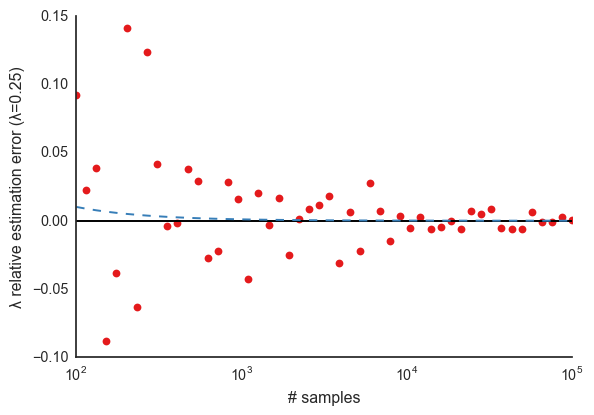

In [103]:
λ = 1/exp.mean()
plt.plot(nsamples, (estimates/λ - 1), 'o')
plt.axhline(0, color='k')
plt.plot(nsamples, nsamples/(nsamples - 1) - 1, '--') # excepted bias
plt.xscale('log')
plt.xlabel('# samples')
plt.ylabel('λ relative estimation error (λ={})'.format(1/exp.mean()))
sns.despine()

To show the importance of the number of samples, we draw n=10, 100 or samples from an exponential distribution multiple times and show the distribution of $\hat{\lambda}$.

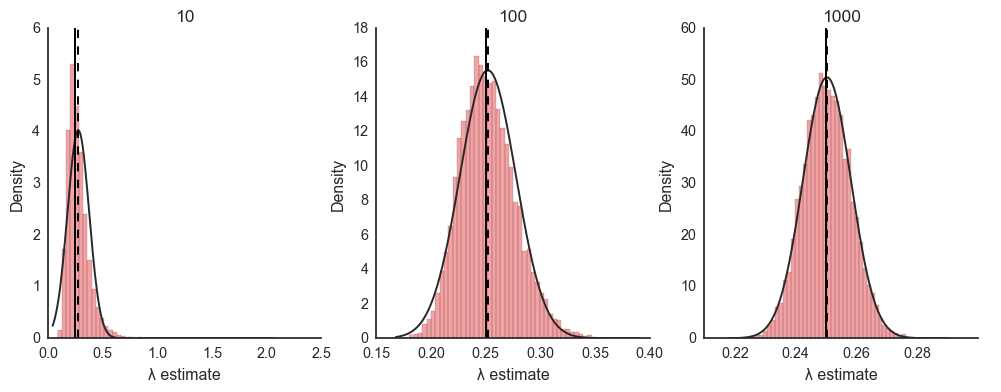

In [91]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
reps = 10000
for i, n in enumerate([10, 100, 1000]):
    estimates = [
        1/exp.rvs(n).mean()
        for _ in range(reps)
    ]
    sns.distplot(estimates, kde=False, fit=stats.norm, ax=ax[i])
    ax[i].axvline(x=λ, color='k', ls='-')
    ax[i].axvline(x=λ * n/(n-1) , color='k', ls='--')
    ax[i].set(
        title=n,
        xlabel=('λ estimate'),
        ylabel=('Density')
    )
sns.despine()

The red bars show the histogram; the black curve is a fitted normal distribution; the solid vertical line is the real value, $\lambda$; the dashed line is the expected estimator, $\frac{n}{n-1}\lambda$. You can see the differencet scales on the x-axis, and that as the distribution becomes narrower it is less biased towards positive values - and the estimator converges to the real value.

#### Bias of $\hat{\lambda}$

Note that the sum of iid exponentials is Gamma distributed: $y=\sum_{i=1}^{n}{x_i} \sim Gamma(n, \frac{1}{\lambda})$ (with $(k,\theta)$ parameterization).

What is the expected estimation?

\begin{multline}
E[\hat{\lambda}] = \\
E[\frac{n}{\sum_{i=1}^{n}{x_i}}] = \\ 
n E[\frac{1}{y}] =\\
n \int_{0}^{\infty}{\frac{1}{y} \frac{\lambda^n y^{n-1}}{\Gamma(n)} e^{-\lambda y} dy} = \\
n \frac{\lambda^n}{\Gamma(n)} \int_0^{\infty}{y^{n-2} e^{-\lambda y} dy} = \\
n \frac{\lambda^n}{\Gamma(n)} \frac{1}{\lambda} \lambda^{2-n} \Gamma(n-1) = \\
\frac{\lambda^{2-n} \lambda^n n \Gamma(n-1)}{\lambda \Gamma(n)} = \\
\frac{n-1}{n} \lambda
\end{multline}

## Exponential regression

Now we have some measurements $x$ and $y$ where $x_i$ is independent variable in $R$ and $y_i>0$ is exponentially distributed with $\lambda_i = g(x_i)$. We are interested in $g(x)$. 

Since we know nothing about $g(x)$ we will attempt to approximate it using a linear model: 
$$
g(x) \approx a x + b
$$

For an indepth description of this approach, see [In All Likelihood](https://www.goodreads.com/book/show/2019845.In_All_Likelihood) by [Yudi Pawitan](http://fafner.meb.ki.se/personal/yudpaw/), Ch. 6 and specifically section 6.5 (pg. 163).

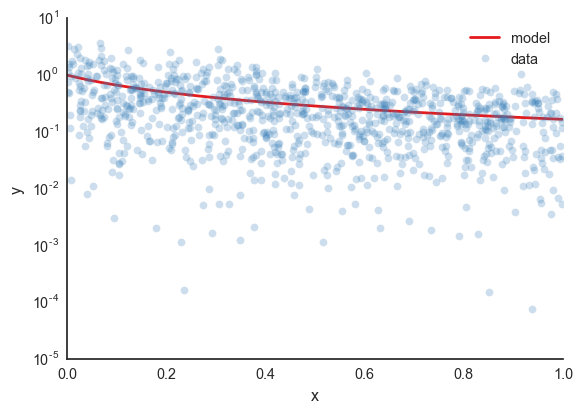

In [104]:
n = 1000
a, b = 5, 1
x = np.random.random(n)
x.sort()
y = stats.expon.rvs(scale=1/(a * x + b))
plt.plot(x, 1/(a * x + b), lw=2, label='model')
plt.plot(x, y, 'o', alpha=0.25, label='data')
plt.xlabel('x')
plt.ylabel('y')
plt.yscale('log')
plt.legend()
sns.despine()

We can now try to estimate $a, b$ from the data.

The likelihood function for $a,b$ given $x,y$ is:
$$
L(a, b | x, y) = \Pi_i {(a x_i + b) \cdot e^{-y_i (a x_i + b)}}
$$

The log-likelihood is nicer as it has a sum rather then a product:
$$
logL(a, b | x, y) = \sum_i{[log{(a x_i + b)} -y_i (a x_i + b)]}
$$

We define the corresponding Python, but it will be the funciton of the negative log-likelihood, so that we can minimize it (rather than maximize it).

In [105]:
def nloglik(params, x, y):
    a, b =  params
    return -np.sum(
        [
            np.log(a * xi + b) - yi * (a * xi + b)
            for xi, yi in zip(x, y)
        ]
    )

In [106]:
res = optimize.minimize(nloglik, (2, 2), args=(x, y))
ahat, bhat = res.x
print('{:.2f} ~ {:.4f}'.format(a, ahat))
print('{:.2f} ~ {:.4f}'.format(b, bhat))

5.00 ~ 5.2387
1.00 ~ 1.0276


Fortunately, we don't have to do this manually; rather, we can use the [statsmodels](http://statsmodels.sourceforge.net/) package. The package has tools for [GLM fitting](http://statsmodels.sourceforge.net/devel/examples/notebooks/generated/glm.html). We need to specify a distribution (family) and possibly a link function (here the inverse function which links the average of $y$ to the distribution parameter $\lambda$). The appropriate distribution is gamma, which is a generaliztion of the exponential distribution, adding a dispersal/variance parameter (see below).

In [107]:
x1 = sm.add_constant(x, prepend=False) # add intercept - b
glm = sm.GLM(y, x1, family=sm.families.Gamma())
results = glm.fit()
results.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 1000
Model:                            GLM   Df Residuals:                      998
Model Family:                   Gamma   Df Model:                            1
Link Function:          inverse_power   Scale:                  0.939649115977
Method:                          IRLS   Log-Likelihood:                 173.02
Date:                Sun, 11 Dec 2016   Deviance:                       1174.4
Time:                        16:33:28   Pearson chi2:                     938.
No. Iterations:                     8                                         
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             5.2387      0.337     15.523      0.000         4.577     5.900
const          1.0276      0.109      9.441      0.000         0.814     1.241
==============================================================================
"""

The coefs for `x1` and `const` are $a$ and $b$.

Some advantages for using _statsmodels_:
- Faster (~100-fold in this example)
- Doesn't require initial guess for the parameters
- More general, as it estimates gamma instead of exponential
- Gives more statistical information like P-values (the `P>|z|` column) and confidence intervals on the coefs (last column).

Next we plot the results.

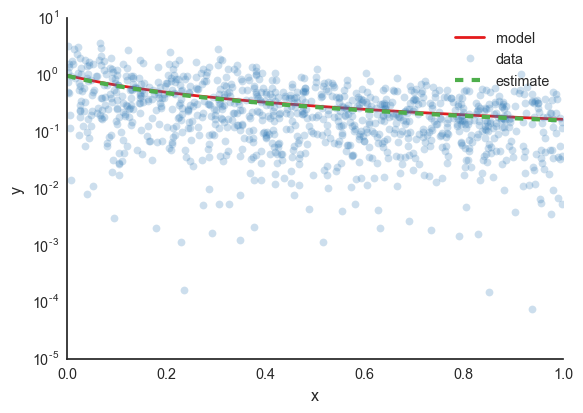

In [108]:
ahat, bhat = results.params

plt.plot(x, 1/(a * x + b), lw=2, label='model')
plt.plot(x, y, 'o', alpha=0.25, label='data')
plt.plot(x, 1/(ahat * x + bhat), lw=3, ls='--', label='estimate') 
#plt.plot(x, results.predict(x1), lw=3, ls='--', label='estimate') # same as above line
plt.xlabel('x')
plt.ylabel('y')
plt.yscale('log')
plt.legend()
sns.despine()

#### Residuals analysis

If the regression model is suitable for the data, we expect that the deviance residuals will be normally distributed - that the estimation error is normal.

The left plot shows a histogram of the residuals, fitted with a normal distribution; the right plot shows a QQ plot that plots the empirical quantiles of the residuals on y-axis vs. the theoretical quantiles on the x-axis. Both plots suggest that the residuals are normally distributed, which is good.

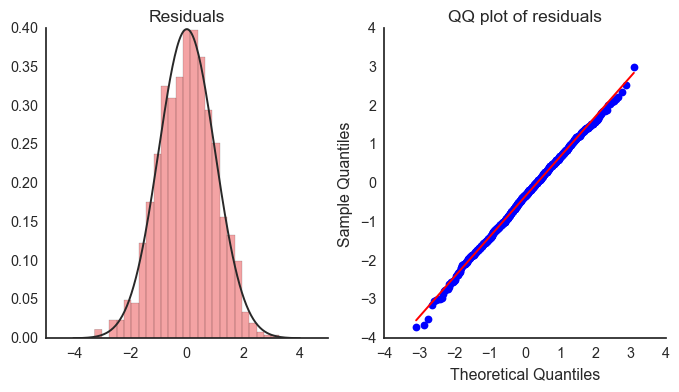

In [152]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

resid = results.resid_deviance.copy()
resid_std = stats.zscore(resid)
sns.distplot(resid_std, bins=25, kde=False, fit=stats.norm, ax=ax[0])
ax[0].set_title('Residuals')

sm.graphics.qqplot(resid, line='r', ax=ax[1])
ax[1].set_title('QQ plot of residuals')

sns.despine()

Calculate and plot the log-likelihood for combinations of $a,b$.

In [12]:
def plot_loglik(L, xrange, yrange, xlabel=None, ylabel=None, cmap='viridis'):
    fig, ax = plt.subplots()            
    im = ax.imshow(L.T, cmap=cmap, aspect=1, origin=(0,0))
    cntr = ax.contour(L.T, N=5, aspect=1, linewidths=0.5, linestyles='--', colors='k')
    ax.clabel(cntr, colors="#252525", fmt=lambda x: '{:.0f}'.format(x))
    plt.colorbar(im, ax=ax, label='Log Likelihood', fraction=0.03, pad=0.25, format='%1.e')
    xstep = len(xrange) // 5
    xticks = list(range(0, len(xrange), xstep)) + [len(xrange)-1]
    xticklabels = xrange[xticks]
    ax.set_xticks(xticks)
    ax.set_xticklabels(['{:.2g}'.format(x) for x in xticklabels], rotation='vertical')

    ystep = len(xrange) // 5
    yticks = list(range(0, len(yrange), ystep)) + [len(yrange)-1]
    yticklabels = yrange[yticks]
    ax.set_yticks(yticks)
    ax.set_yticklabels(['{:.2g}'.format(y) for y in yticklabels])

    imax, jmax = (L == np.nanmax(L)).nonzero()
    ax.scatter(imax, jmax, marker='o', s=50, color='r')
    ax.set(
        xlabel=xlabel,
        ylabel=ylabel
    )
        
    fig.tight_layout()
    sns.despine()
    return fig, ax

/Users/yoavram/miniconda3/envs/simarba/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in log


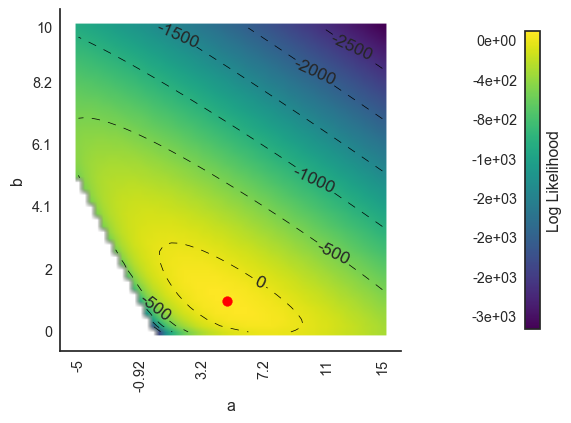

In [13]:
arange = np.linspace(-5, 15)
brange = np.linspace(0, 10)
logL = np.array([
    [
        -nloglik((a, b), x, y)
        for b in brange
    ]
    for a in arange
])

fig, ax = plot_loglik(logL, arange, brange, xlabel='a', ylabel='b')

The red dot marks the maximum likelihood.

Next, a likelihood profile for $a$:

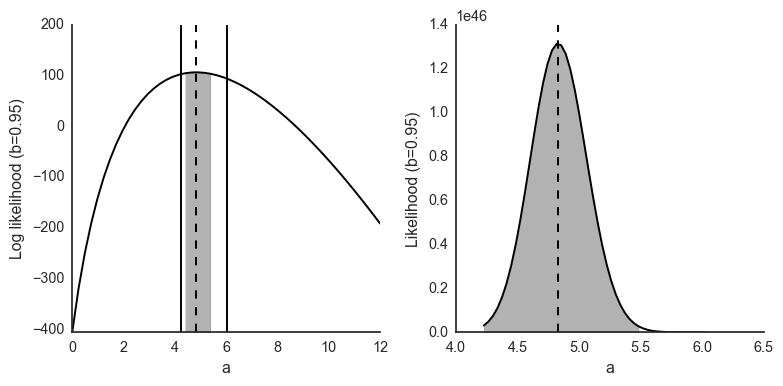

In [14]:
fig, ax = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(8, 4))

alow, ahigh = results.conf_int()[0,:]
arange = np.linspace(0, 12)
idx = (arange > alow) & (arange < ahigh)
logL = np.array([
    -nloglik((a, bhat), x, y)   
    for a in arange
])

ax[0].plot(arange, logL, 'k-')
ax[0].axvline(ahat, color='k', ls='--')
ax[0].fill_between(arange[idx], np.nanmin(logL), logL[idx], color='k', alpha=0.3)
ax[0].set(
    xlabel='a',
    ylabel='Log likelihood (b={:.2f})'.format(bhat),
    ylim=(np.nanmin(logL), None),
)

arange = np.linspace(ahat*0.875, ahat*1.25)
ax[0].axvline(arange.min(), ls='-', color='k')
ax[0].axvline(arange.max(), ls='-', color='k')
idx = (arange > alow) & (arange < ahigh)
logL = np.array([
    -nloglik((a, bhat), x, y)
    for a in arange
])

ax[1].plot(arange, np.exp(logL), 'k-')
ax[1].axvline(ahat, color='k', ls='--')
ax[1].fill_between(arange[idx], np.nanmin(np.exp(logL)), np.exp(logL[idx]), color='k', alpha=0.3)
ax[1].set(
    xlabel='a',
    ylabel='Likelihood (b={:.2f})'.format(bhat),
)

fig.tight_layout()
sns.despine()

The left panel shows a plot of the log-likelihood for the estimated $b$ and different values of $a$. The dashed line is for the estimated $a$; the shaded ares is the 95% confidence interval; the solid lines show the area presented in the right panel.

The right panel shows the likelihood (no log) for different $a$ values. The dashed line is for the estimated $a$; the shaded ares is the 95% confidence interval.

# Example: adaptation time

We simulate adaptation using a Wright-Fisher model with a single bi-allelic locus and an asexual haploid constant size population.
The simulation starts with a population of size _N_, all with allele _a_ that confers fitness _1-s_.
Allele _A_, confering fitness 1, appears with probability _u_ via mutation.

The expected frequency of allele _A_ is:
$$
E[p(t+1)] = \frac{p(t) \cdot (1-u) + (1-p(t)) \cdot (1-s) \cdot u}{\bar{\omega}} \\
\bar{\omega} = p(t) + (1-p(t)) \cdot (1-s)
$$

The frequency of allele _A_ in the next generation is:
$$
n(t+1) \sim Bin(N, E[p(t+1)]) \\
p(t+1) = n(t+1) / N
$$
that is, $n(t)$, the number of alleles _A_, is binomialy distributed.

We are looking for the first time $T$ at which $p(T)=1$.

Progress: 
 
 
 
 
 Starting...

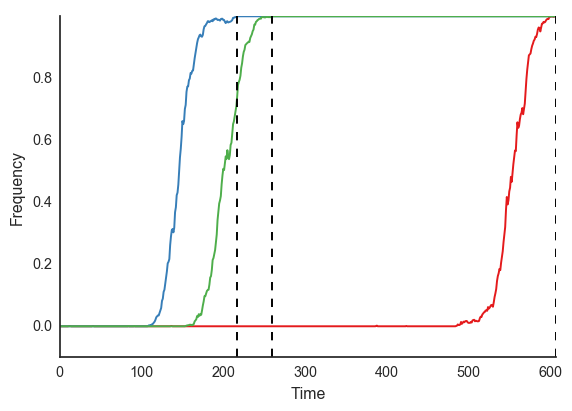

In [154]:
def simulate_adaptation(s, N, u, reps=1, PRINT=False, PLOT=False, BAR=False):
    N = int(N)
    p = np.zeros(reps, dtype=float)
    T = np.zeros(reps, dtype=int)
    t = 0
    if PLOT:
        ps = []    
    if BAR:
        bar = ProgressBar(reps)
        bar.start()
    while not np.allclose(p, 1):
        if PRINT and t % 500 == 0:
            print("{} {:.2g}".format(t, (p<1).mean()), end=" | ")
        if BAR:
            finished = ((T == 0) & (p == 1)).sum()
            for _ in range(finished):
                bar.advance()
        T[(T == 0) & (p == 1)] = t
        assert ((0 <= p) & (p <= 1)).all()
        if PLOT: ps.append(p)
        # selection and mutation
        w = p + (1 - p) * (1 - s)
        p = (p + (1 - p) * (1 - s) * u) / w
        # random genetic drift
        p = np.random.binomial(N, p) / N
        t += 1
    
    if PLOT:
        ps = np.array(ps)
        plt.plot(range(t), ps)
        plt.ylim(-0.1, 1)
        plt.xlim(0, max(10, t))
        plt.xlabel("Time")
        plt.ylabel("Frequency")
        
    T[T == 0] = t
    if BAR:
        bar.finish()
        bar.hide()
    return T

T = simulate_adaptation(0.1, 1e3, 1e-5, 3, BAR=True, PLOT=True)
for t in T:
    plt.axvline(t, ls='--', color='k')
sns.despine()

This shows three popoulations adapting, each one finishing adaptation at a different time.

We now simulate lots of adaptaions and present the:
- mean adaptation time: the average of the times
- the expected value of a fitted exponential distribution
- the theoretical approximation to the geometric adaptation time: $T \approx \frac{1}{2s N u} + \frac{\log{N}}{s}$

In [12]:
T = simulate_adaptation(0.01, 1e5, 1e-7, 10, BAR=True)

Progress: 
 
 
 
 
 Starting...

Mean T: 6664
Estimated T: 5212
Theoretical T: 5921


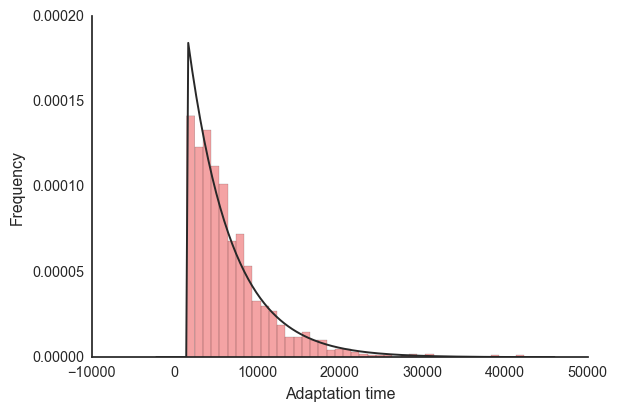

In [8]:
T_mean = T.mean()
T_est = stats.expon.fit(T)[1]
T_theo = 1/(2*0.01*1e4*1e-6) + np.log(1e4)/0.01
print("Mean T: {:.0f}\nEstimated T: {:.0f}\nTheoretical T: {:.0f}".format(T_mean, T_est, T_theo))
sns.distplot(T, kde=False, fit=stats.expon)
plt.xlabel('Adaptation time')
plt.ylabel('Frequency')
sns.despine()

## Mixed parameters

In the above, there was a single set of parameters $(N, s, u)$.

Now, let's simulate adaptations with a bunch of parameters and use *exponential regression*!

We randomize 100 parameter sets, and run 5 simulations for each set; this can take some time, especially when the adaptation time is long.

In [159]:
#  pip install git+https://github.com/rossant/ipycache --upgrade
%load_ext ipycache

The ipycache extension is already loaded. To reload it, use:
  %reload_ext ipycache


In [221]:
%%cache mycache.pkl dfs --force
dfs = []
for _ in range(100):
    print(_, end=' ')
    s = np.random.uniform(0.01, 0.1)
    N = 10**np.random.uniform(4, 7)
    u = 10**np.random.uniform(-6, -9)
    T = simulate_adaptation(s, N, u, 5)
    dfs.append(pd.DataFrame(dict(s=s, N=N, u=u, T=T)))

[Saved variables 'dfs' to file '/Users/yoavram/Work/ipython-notebooks/mycache.pkl'.]
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 

We now fit exponential regression to the simulated data.

The idea is that we assume that the response variable - T, the adaptation time - is exponentialy distributed with rate $\lambda(N, s, u)$ that is a linear function of the parameters:

$$
T \sim Exp(\lambda(N, s, u)) \\ 
E[1/T] = 
\lambda(N, s, u) = c_0 + c_N N + c_s s + c_u u
$$

Run the regression:

In [227]:
df = pd.concat(dfs, axis=0)
X = df[['N', 's', 'u']]
y = df['T']

X = sm.add_constant(X) # add intercept
distribution = sm.families.Gamma(sm.genmod.families.links.inverse_power)
glm = sm.GLM(y, X, family=distribution)
results = glm.fit()
results.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      T   No. Observations:                  600
Model:                            GLM   Df Residuals:                      597
Model Family:                   Gamma   Df Model:                            2
Link Function:          inverse_power   Scale:                   2.17625596808
Method:                          IRLS   Log-Likelihood:                -5599.3
Date:                Sun, 11 Dec 2016   Deviance:                       695.49
Time:                        17:44:34   Pearson chi2:                 1.30e+03
No. Iterations:                    10                                         
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const      -1.052e-05   4.27e-06     -2.463      0.014     -1.89e-05 -2.15e-06
N           1.347e-10   1.61e-11      8.382      0.000      1.03e-10  1.66e-10
s              0.0002   9.92e-05      2.109      0.035      1.48e-05     0.000
u           2363.3384    213.612     11.064      0.000      1944.667  2782.010
==============================================================================
"""

Residuals analysis:

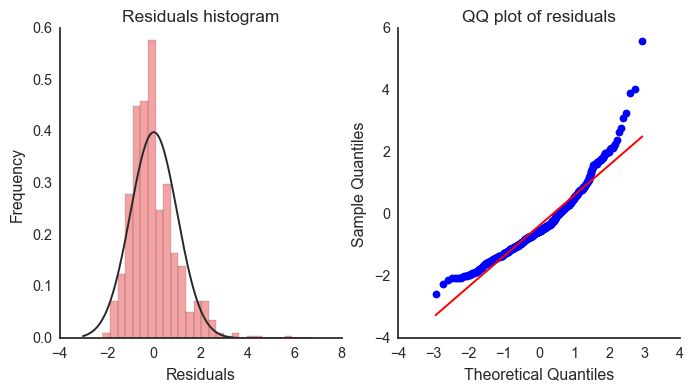

In [231]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

resid = results.resid_deviance.copy()
resid_std = stats.zscore(resid)
sns.distplot(resid_std, bins=25, kde=False, fit=stats.norm, ax=ax[0])
ax[0].set(
    title='Residuals histogram',
    xlabel='Residuals',
    ylabel='Frequency'
)

sm.graphics.qqplot(resid, line='r', ax=ax[1])
ax[1].set_title('QQ plot of residuals')

sns.despine()

We found that the effects of $N, s, u$ are all measurable (low P-value), although the effect of $s$ is less so.

What about the effect sizes?

- Increasing the population size by one individual will increase the adaptation rate by ~2e-11; this doesn't seem like much, but it can accumulate when adding millions of individuals.
- Increasing of the selection coefficient by 0.01  (1% stronger selection) will increase the adaptation rate by ~4e-7.
- The interpretation for the mutation rate is more complicated - it is a probability so not sure what increase should be looked at.

Importanty, we find that increasing all 3 parameters will increase the adaptation rate (and decrease adaptation time).

Let's look at the real adaptation times vs. the regression estimates:

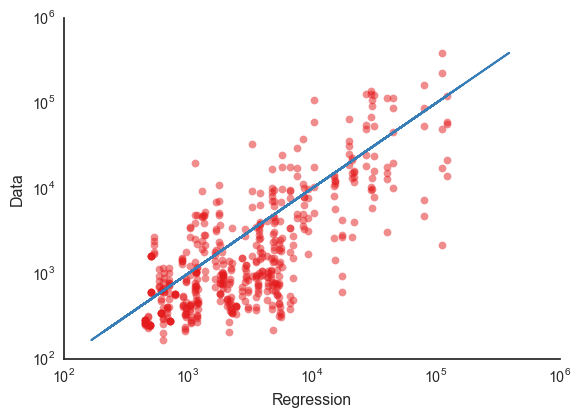

In [219]:
fig, ax = plt.subplots()

ax.plot(results.predict(X), y, 'o', alpha=0.5)
ax.plot(y, y, '-')
ax.set(
    xscale=('log'),
    yscale=('log'),
    xlabel=('Regression'),
    ylabel=('Data')
)
sns.despine()

Hmm... not amazing, but clear correlation.

Let's plot regression plots, in which we fix two parameters and vary one varaible, and compare the data to the regression plot, which estimates the average adaptation time. Remember that an exponential distribution is not symmetrical around the mean: we expect that ~60% of the samples will be below the estimated mean.

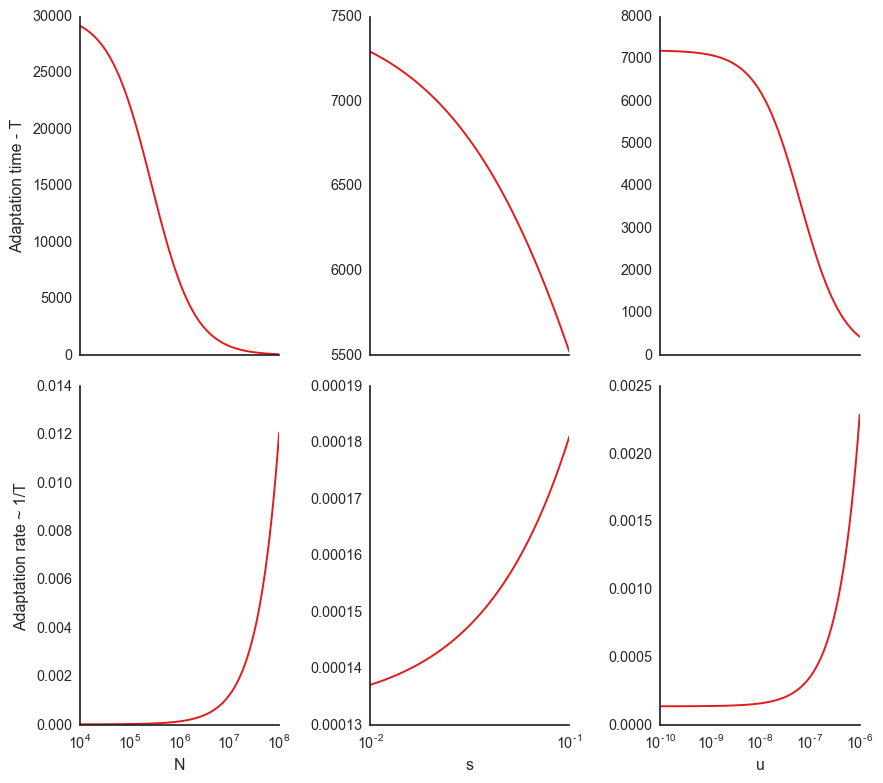

In [187]:
c0, cN, cs, cu = results.params.values

N = np.logspace(4, 8, 100)
s = np.linspace(0.01, 0.1, 100)
u = np.logspace(-6, -10, 100)

TN = results.predict(pd.DataFrame(dict(const=1, N=N, s=s[50], u=u[50])))
Ts = results.predict(pd.DataFrame(dict(N=N[50], s=s, u=u[50], const=1)))
Tu = results.predict(pd.DataFrame(dict(N=N[50], s=s[50], u=u, const=1)))

TN = 1/(c0 + cN * N + cs * s[50] + cu * u[50])
Ts = 1/(c0 + cN * N[50] + cs * s + cu * u[50])
Tu = 1/(c0 + cN * N[50] + cs * s[50] + cu * u)

fig, ax = plt.subplots(2, 3, figsize=(9, 8), sharey=False, sharex='col')
ax[0,0].plot(N, TN)
ax[0,1].plot(s, Ts)
ax[0,2].plot(u, Tu)
ax[1,0].plot(N, 1/TN)
ax[1,1].plot(s, 1/Ts)
ax[1,2].plot(u, 1/Tu)
ax[0,0].set(ylabel='Adaptation time - T')
ax[1,0].set(xscale='log', xlabel='N', ylabel='Adaptation rate ~ 1/T')
ax[1,1].set(xlabel='s', ylabel='', xscale='log')
ax[1,2].set(xscale='log', xlabel='u', ylabel='')

fig.tight_layout()
sns.despine()